In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from collections import Counter


data = pd.read_csv('../data/imdb_reviews.csv')

In [5]:
print(data.head())

   Unnamed: 0                                             review  label
0       18245  This short spoof can be found on Elite's Mille...      0
1       19801  A singularly unfunny musical comedy that artif...      0
2        3222  An excellent series, masterfully acted and dir...      1
3        6010  The master of movie spectacle Cecil B. De Mill...      1
4       16355  I was gifted with this movie as it had such a ...      0


In [12]:
def plot_language_distribution(df, review_column='review'):
    """
    Detects language of each review and plots frequency bar chart with count labels.

    Parameters:
        df (pd.DataFrame): The input dataframe with a column containing text reviews.
        review_column (str): The name of the column containing review text.

    Returns:
        pd.Series: Language counts
    """
    # Detect language
    df['language'] = df[review_column].apply(lambda x: detect(x) if pd.notnull(x) else 'unknown')

    # Count languages
    language_counts = df['language'].value_counts()

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')

    # Add count labels on top of bars
    for i, value in enumerate(language_counts.values):
        ax.text(i, value + max(language_counts.values)*0.01, str(value),
                ha='center', va='bottom', fontweight='bold')

    plt.title('Language Frequency in Reviews')
    plt.xlabel('Language Code')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return language_counts

/var/folders/z7/x4knhjws2j5_f23y0s962bdr0000gn/T/ipykernel_26509/3184381935.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')


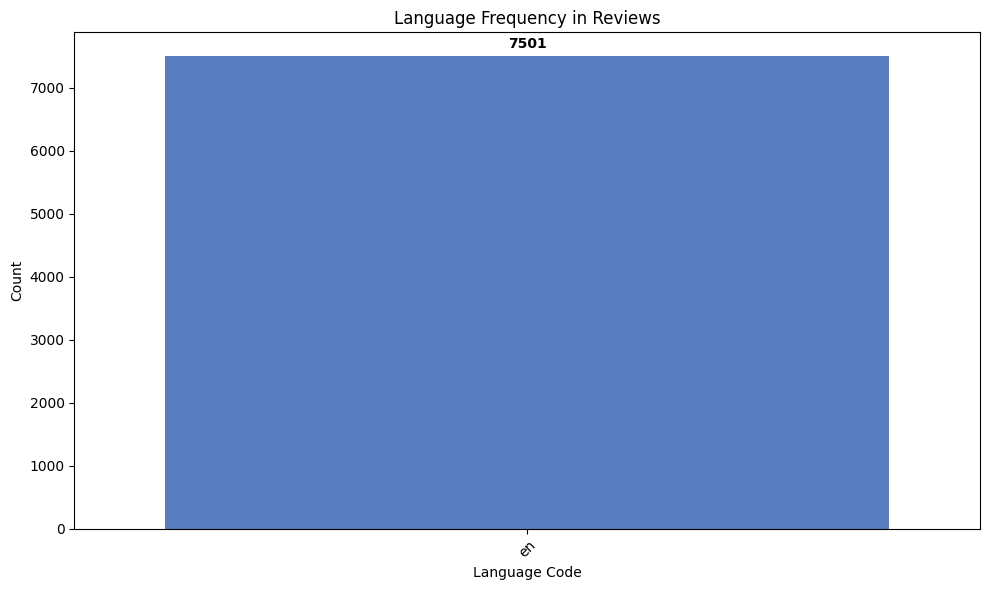

In [15]:
language_distribution = plot_language_distribution(data)

/var/folders/z7/x4knhjws2j5_f23y0s962bdr0000gn/T/ipykernel_26509/3184381935.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')


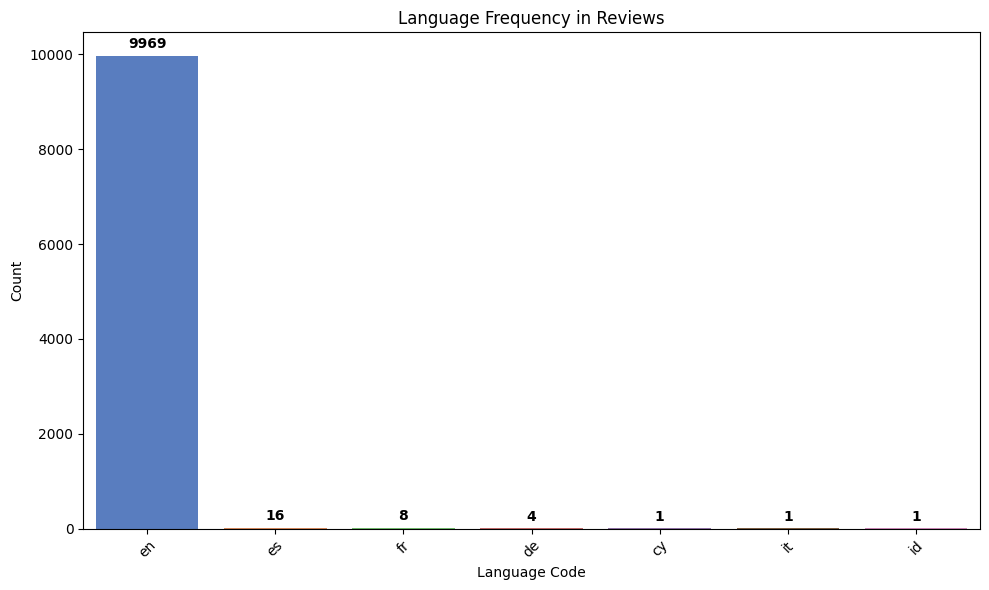

In [13]:
amazon_data = pd.read_csv('../data/amazon_reviews.csv')
language_distribution_am = plot_language_distribution(amazon_data)

/var/folders/z7/x4knhjws2j5_f23y0s962bdr0000gn/T/ipykernel_26509/3184381935.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')


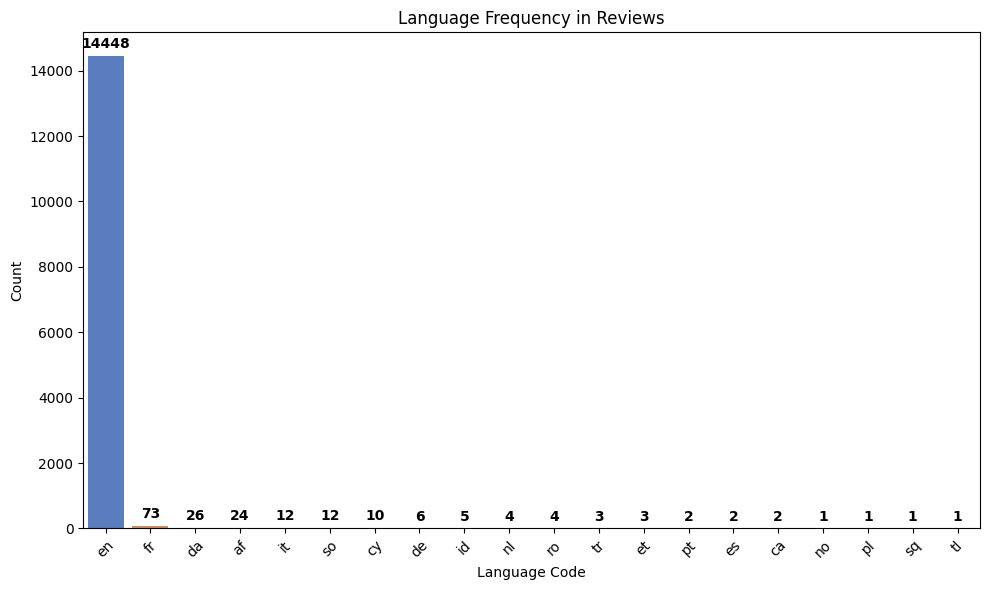

In [14]:
tweeter_data = pd.read_csv('../data/tweets.csv')
language_distribution_tw = plot_language_distribution(tweeter_data, review_column='text')

In [16]:
from langdetect import detect
from googletrans import Translator

translator = Translator()

#translate to english if needed
def detect_and_translate(text):
    try:
        lang = detect(text)
        if lang != 'en':
            translation = translator.translate(text, dest='en')
            return translation.text
        return text
    except:
        return text

data['translated_review'] = data['review'].apply(detect_and_translate)


/Users/catalinamacovei/PycharmProjects/SentimentAnalysis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [17]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    # rm punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # tokenization
    tokens = word_tokenize(text)
    # rm stopwords, they are too frequent
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

data['cleaned_review'] = data['translated_review'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catalinamacovei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/catalinamacovei/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
print(data.head())

   Unnamed: 0                                             review  label  \
0       18245  This short spoof can be found on Elite's Mille...      0   
1       19801  A singularly unfunny musical comedy that artif...      0   
2        3222  An excellent series, masterfully acted and dir...      1   
3        6010  The master of movie spectacle Cecil B. De Mill...      1   
4       16355  I was gifted with this movie as it had such a ...      0   

  language                                  translated_review  \
0       en  This short spoof can be found on Elite's Mille...   
1       en  A singularly unfunny musical comedy that artif...   
2       en  An excellent series, masterfully acted and dir...   
3       en  The master of movie spectacle Cecil B. De Mill...   
4       en  I was gifted with this movie as it had such a ...   

                                      cleaned_review  sentiment_score  \
0  short spoof found elites millennium edition dv...        -0.156667   
1  singularl

In [20]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

data['sentiment_score'] = data['cleaned_review'].apply(get_sentiment)
data['sentiment_label'] = data['sentiment_score'].apply(
    lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
)


In [24]:
    neutral_reviews = data[data['sentiment_label'] == 'neutral']

    print(f"\nTotal neutral reviews: {len(neutral_reviews)}\n")



Total neutral reviews: 6



In [28]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from nltk import word_tokenize, pos_tag

def extract_emotional_words(text):
    if pd.isnull(text):
        return ""

    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Only adjectives and adverbs (JJ, JJR, JJS, RB, RBR, RBS)
    emotional_words = [word for word, tag in pos_tags if tag.startswith('JJ') or tag.startswith('RB')]
    return ' '.join(emotional_words)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/catalinamacovei/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catalinamacovei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds(df, text_column='cleaned_review', sentiment_column='sentiment_label'):
    """
    Plots WordClouds showing only emotional words (adjectives/adverbs) for each sentiment.
    """
    sentiments = ['positive', 'neutral', 'negative']
    colors = ['Greens', 'Blues', 'Reds']

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for i, sentiment in enumerate(sentiments):
        subset = df[df[sentiment_column] == sentiment]
        emotional_text = ' '.join(subset[text_column].dropna().apply(extract_emotional_words))

        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colors[i]).generate(emotional_text)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{sentiment.capitalize()} Reviews (Emotional Language)', fontsize=18)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


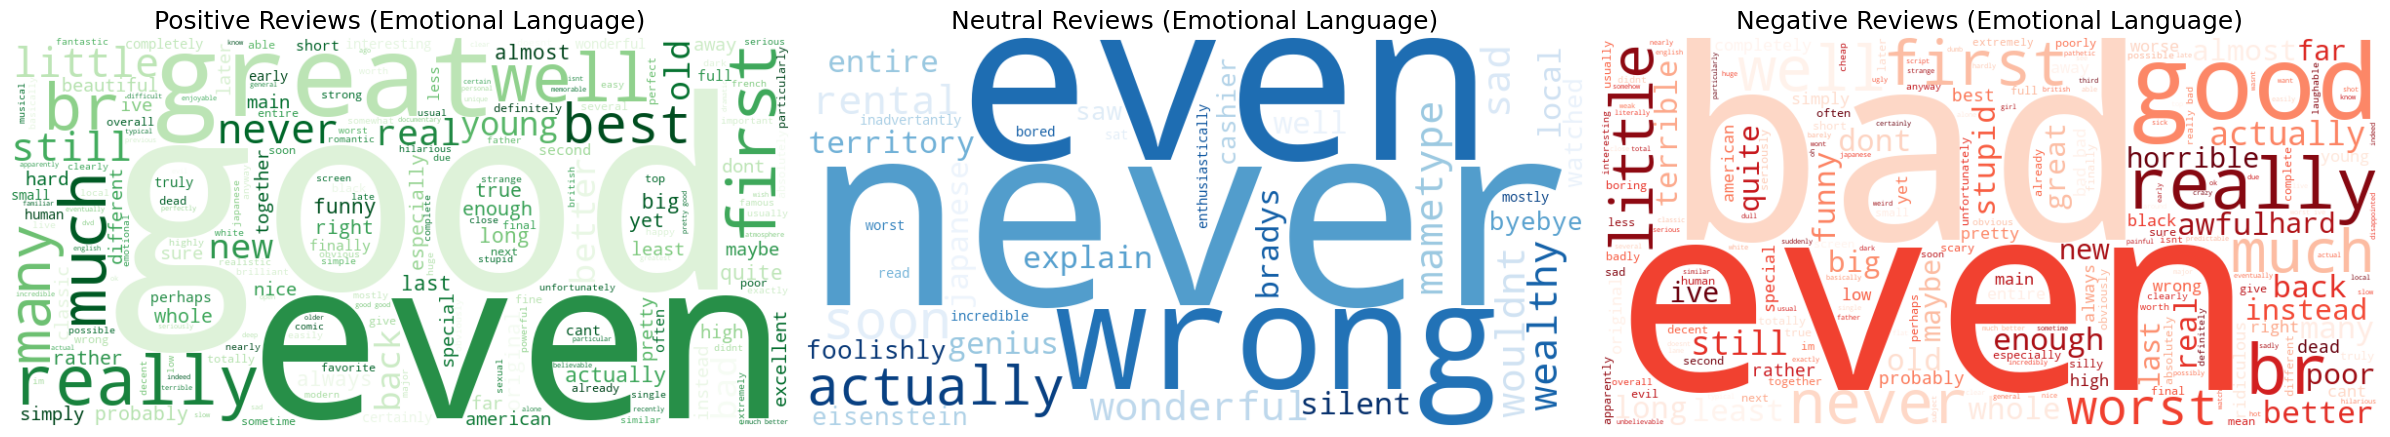

In [35]:
plot_wordclouds(data)